In [ ]:
#Plotting libraries:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch


import pandas as pd
import numpy as np

import os, sys


'''
# TensorFlow, Keras, PyTorch and DeepXDE
#!pip install tensorflow
import tensorflow as tf
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

#tf.compat.v1.enable_eager_execution()

from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import backend as K
'''

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from tensorflow.keras import backend as K


#tf.compat.v1.enable_eager_execution()


#Import tqdm for progress bar
from tqdm import tqdm

!pip install pyDOE
from pyDOE import lhs

import operator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18167 sha256=bcf5f8346bb4ebb4ae68797b56d9608fbd800711f5acddcd6e59c5b6056fc8cd
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
no_x = 151
no_y = 51

x_span = 30
y_span = 10


dx = x_span / (no_x - 1)
dy = y_span / (no_y - 1)

x = np.linspace(0, x_span, no_x)
y = np.linspace(0, y_span, no_y)

Xvalues_mesh, Yvalues_mesh = np.meshgrid(x, y)


print(Xvalues_mesh)
print()
print(Yvalues_mesh)

[[ 0.   0.2  0.4 ... 29.6 29.8 30. ]
 [ 0.   0.2  0.4 ... 29.6 29.8 30. ]
 [ 0.   0.2  0.4 ... 29.6 29.8 30. ]
 ...
 [ 0.   0.2  0.4 ... 29.6 29.8 30. ]
 [ 0.   0.2  0.4 ... 29.6 29.8 30. ]
 [ 0.   0.2  0.4 ... 29.6 29.8 30. ]]

[[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.2  0.2  0.2 ...  0.2  0.2  0.2]
 [ 0.4  0.4  0.4 ...  0.4  0.4  0.4]
 ...
 [ 9.6  9.6  9.6 ...  9.6  9.6  9.6]
 [ 9.8  9.8  9.8 ...  9.8  9.8  9.8]
 [10.  10.  10.  ... 10.  10.  10. ]]


In [ ]:
#MLP -> Resnet
class pinn(tf.keras.Model): #Physics Informed Neural Network

  def __init__(self):
    '''define the layers
    '''
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(100, activation=tf.nn.tanh) # sin, siwsh -> x(sigmoid(a*x))
    self.dense2 = tf.keras.layers.Dense(100, activation=tf.nn.tanh)
    self.dense3 = tf.keras.layers.Dense(100, activation=tf.nn.tanh)
    self.dense4 = tf.keras.layers.Dense(100, activation=tf.nn.tanh)
    self.output_layer = tf.keras.layers.Dense(1)


  def call(self, inputs):
    '''feed layers forward into each other (feed forward network)
    '''
    x = self.dense1(inputs)
    x = self.dense2(x)
    x = self.dense3(x)
    x = self.dense4(x)
    x = self.output_layer(x)


    return x

batch_size = 1000
model = pinn()
model.build(input_shape=( None, 3)) #build network + input shape
model.summary()

Model: "pinn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  400       
                                                                 
 dense_1 (Dense)             multiple                  10100     
                                                                 
 dense_2 (Dense)             multiple                  10100     
                                                                 
 dense_3 (Dense)             multiple                  10100     
                                                                 
 dense_4 (Dense)             multiple                  101       
                                                                 
Total params: 30,801
Trainable params: 30,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
@tf.function
def pde(X):
  '''pde loss

  X: a grid of x, y and t values of the whole domain
  '''


  x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
  u  = model(tf.concat([x, y, t], 1)) #u from the NN when x, y, t are inputted


  du_x, du_y, du_t = tf.gradients(u, x)[0] , tf.gradients(u, y)[0], tf.gradients(u, t)[0]

  du_xx = tf.gradients(du_x, x)[0] # check sizes
  du_yy = tf.gradients(du_y, y)[0]

  constant = (8.96*1.46)/385



  return tf.reduce_mean(tf.square(   du_t - constant*(du_xx + du_yy)  )   ) #loss (reduced mean error squared)


In [ ]:
@tf.function #EACH LOSS BASICALLY = WHAT WE ARE TRYING TO GET TO FOR EACH THING
def block(X):
  '''block loss (inside)

  X: a grid of x, y and t values of the block
  '''


  x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
  u  = model(tf.concat([x, y, t], 1)) #u from the NN when x, y, t are inputted

  du_x, du_y, du_t = tf.gradients(u, x)[0] , tf.gradients(u, y)[0], tf.gradients(u, t)[0]

  du_xx = tf.gradients(du_x, x)[0]
  du_yy = tf.gradients(du_y, y)[0]

  constant = (2.70*1.08)/792



  return tf.reduce_mean(tf.square(   du_t - constant*(du_xx + du_yy)  )   ) #loss (reduced mean error squared)

  #return tf.reduce_mean(tf.square(   u )   ) #loss (reduced mean error squared)

In [ ]:
x_range = [0, 30]
y_range = [0, 10]
t_range = [0, 100]



#upper and lower bounds of x, y and t together:
lb = np.array(     [  x_range[0], y_range[0], t_range[0]  ]     )
ub = np.array(     [  x_range[1], y_range[1], t_range[1]  ]     )


copper_block_pos = {
                   'left': 0,       #in terms of x coord
                   'right': 20,      #in terms of x coord
                   'bottom': 0,      #in terms of y coord
                   'top': 10         #in terms of y coord
                  }


#upper and lower bounds of block:
lb = np.array(     [  copper_block_pos['left'],  copper_block_pos['bottom'], t_range[0]  ]       )
ub = np.array(     [  copper_block_pos['right'], copper_block_pos['top'],    t_range[1]  ]       )













glass_block_pos = {
                   'left': 20,       #in terms of x coord
                   'right': 30,      #in terms of x coord
                   'bottom': 0,      #in terms of y coord
                   'top': 10         #in terms of y coord
                  }


#upper and lower bounds of block:
lb_block = np.array(     [  glass_block_pos['left'],  glass_block_pos['bottom'], t_range[0]  ]       )
ub_block = np.array(     [  glass_block_pos['right'], glass_block_pos['top'],    t_range[1]  ]       )




def LHS_Sampling(N, lb, ub ):
  return lb + (ub-lb) * lhs(3, N)



def domain_boundaries(X):
  '''domain boundaries loss

  X: a grid of x, y and t values of the domain boundaries
  '''

  x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
  u  = model(tf.concat([x, y, t], 1)) #u from the NN when x, y, t are inputted


  #du_x, du_y, du_t = tf.gradients(u, x)[0] , tf.gradients(u, y)[0], tf.gradients(u, t)[0]

  #du_xx = tf.gradients(du_x, x)[0]
  #du_yy = tf.gradients(du_y, y)[0]

  #constant = (8.96*1.46)/385



  #return tf.reduce_mean(tf.square(   du_t - constant*(du_xx + du_yy)  )   ) #loss (reduced mean error squared)

  return tf.reduce_mean(tf.square( u) )









def bound_block_vert(X):
  '''loss for the vertical boundaru of the block

  X: a grid of x, y and t values of the block's vertical boundary
  '''


  x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
  u  = model(tf.concat([x, y, t], 1)) #u from the NN when x, y, t are inputted

  #du_x, du_y, du_t = tf.gradients(u, x)[0] , tf.gradients(u, y)[0], tf.gradients(u, t)[0]

  #du_xx = tf.gradients(du_x, x)[0]
  #du_yy = tf.gradients(du_y, y)[0]

  #constant = (2.70*1.0.8)/792



  #return tf.reduce_mean(tf.square(   du_t - constant*(du_xx + du_yy)  )   ) #loss (reduced mean error squared)

  return tf.reduce_mean(tf.square( u) )

In [ ]:
def normalize(x, range):
  return ((x - range[0]) / (range[1]-range[0]))

In [ ]:
@tf.function
def ini_transfer_speed(X):
  '''assign initial heat transfer rate (ie du/dt)

  X: a grid of x, y and t values of the whole domain
  '''

  x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
  #x=normalize(x, x_range)
  u  = model(tf.concat([x, y, t], 1)) #u from the NN when x, y, t are inputted


  u_t = tf.gradients(u, t)[0] #transfer rate
  initial_transf_loss = u_t #transfer rate minimised to 0


  return tf.reduce_mean(tf.square(   initial_transf_loss   )   )



def reconstruction(X, Y):
  '''to get the initial loss

  X: a grid of x, y and t values of the whole initial domain
  '''

  u = model(X)
  recon_loss = u - Y

  return tf.reduce_mean(tf.square(  recon_loss   )  )

In [ ]:
N_i = 1000
N_b = 1000
N_f = 10000

N_blk = 5000

In [ ]:
XY_star = np.hstack((   Xvalues_mesh.flatten()[:, None],  Yvalues_mesh.flatten()[:, None]    ))
print(t_range[0])
dt = 10
t = np.arange(  int(t_range[0]),    int(t_range[1]) +dt ,    dt)

T_star = np.expand_dims(   np.repeat(t, len(XY_star)),   1)

XY_star_tiled = np.tile(  XY_star, (len(t), 1)  )

XYT_star = np.hstack((  XY_star_tiled, T_star  ))


0


In [ ]:
def data_sampling():


  #sampling for whole domain boundaries:
  #X_ic = np.hstack((    XY_star , np.zeros( len(XY_star) ).reshape(  len(XY_star), 1)    ))
  X_ic = LHS_Sampling(N_i, lb, ub)
  X_ic[:, 2:3] = 0

  #idx = np.random.choice(X_ic.shape[0], N_i, replace=False)

  u_ic = np.expand_dims(np.ones(N_i), 1)


  #u_ic = X_ic[:, 3:4]

  #X_i = X_ic[idx]
  #Y_i = u_ic[idx]

  X_i = X_ic
  Y_i = u_ic





  X_left = LHS_Sampling(N_b, lb, ub)
  X_left[:, 0:1] = x_range[0]


  X_right = LHS_Sampling(N_b, lb, ub)
  X_right[:, 0:1] = x_range[1]


  X_bottom = LHS_Sampling(N_b, lb, ub)
  X_bottom[:, 1:2]= y_range[0]


  X_top = LHS_Sampling(N_b, lb, ub)
  X_top[:, 1:2]= y_range[1]


  X_b = np.vstack(  (X_right, X_top, X_left,  X_bottom )  )





  #sampling for block boundaries:
  Xleft_blk = LHS_Sampling(N_blk, lb_block, ub_block)
  Xleft_blk[:, 0:1] = x_range[0]


  Xright_blk = LHS_Sampling(N_blk, lb_block, ub_block)
  Xright_blk[:, 0:1] = x_range[1]


  Xbottom_blk = LHS_Sampling(N_blk, lb_block, ub_block)
  Xbottom_blk[:, 1:2]= y_range[0]


  Xtop_blk = LHS_Sampling(N_blk, lb_block, ub_block)
  Xtop_blk[:, 1:2]= y_range[1]


  X_xblock =  np.vstack(   (Xleft_blk, Xright_blk)    )
  X_yblock = np.vstack(    (Xbottom_blk, Xtop_blk)    )

  X_block_bound = np.vstack(      (Xright_blk,   Xtop_blk,    Xleft_blk,    Xbottom_blk )      )
  X_block = LHS_Sampling(N_blk , lb_block, ub_block)





  X_f = LHS_Sampling(N_f, lb, ub)



  return X_i, Y_i, X_i,  X_b, X_xblock, X_yblock, X_block, X_f, X_block_bound




X_i, Y_i, X_i,  X_b, X_xblock, X_yblock, X_block, X_f, X_block_bound = data_sampling()

In [ ]:
print(X_i)

[[ 9.29161624  2.62793003  0.        ]
 [ 1.32204227  4.40600309  0.        ]
 [18.4182748   2.65421135  0.        ]
 ...
 [ 4.88293645  1.86612704  0.        ]
 [11.67670201  0.48908835  0.        ]
 [16.81508431  5.93739075  0.        ]]


In [ ]:
X_i = tf.convert_to_tensor( X_i, dtype=tf.float32)
Y_i = tf.convert_to_tensor( Y_i, dtype=tf.float32)

#X_right = tf.convert_to_tensor( X_right, dtype=tf.float32)
#X_left = tf.convert_to_tensor( X_left, dtype=tf.float32)

X_b = tf.convert_to_tensor( X_b, dtype=tf.float32)



X_xblock = tf.convert_to_tensor( X_xblock, dtype=tf.float32)
X_yblock = tf.convert_to_tensor( X_yblock, dtype=tf.float32)

X_block_bound = tf.convert_to_tensor( X_block_bound, dtype=tf.float32)



X_block = tf.convert_to_tensor( X_block, dtype=tf.float32)
X_f = tf.convert_to_tensor( X_f, dtype=tf.float32)

Streaming output truncated to the last 5000 lines.
Iteration: 35001, Initial_Loss: 2.209e-05, Boundary_Loss: 7.931e-06, Domain_Loss: 1.588e-04, Block_loss: 4.127e-05
Iteration: 35002, Initial_Loss: 2.349e-05, Boundary_Loss: 1.128e-05, Domain_Loss: 1.611e-04, Block_loss: 4.056e-05
Iteration: 35003, Initial_Loss: 2.189e-05, Boundary_Loss: 1.822e-05, Domain_Loss: 1.582e-04, Block_loss: 4.159e-05
Iteration: 35004, Initial_Loss: 2.448e-05, Boundary_Loss: 2.925e-05, Domain_Loss: 1.623e-04, Block_loss: 4.051e-05
Iteration: 35005, Initial_Loss: 2.115e-05, Boundary_Loss: 5.011e-05, Domain_Loss: 1.580e-04, Block_loss: 4.243e-05
Iteration: 35006, Initial_Loss: 2.603e-05, Boundary_Loss: 8.240e-05, Domain_Loss: 1.658e-04, Block_loss: 4.091e-05
Iteration: 35007, Initial_Loss: 2.061e-05, Boundary_Loss: 1.351e-04, Domain_Loss: 1.586e-04, Block_loss: 4.434e-05
Iteration: 35008, Initial_Loss: 2.820e-05, Boundary_Loss: 2.059e-04, Domain_Loss: 1.722e-04, Block_loss: 4.229e-05
Iteration: 35009, Initial_Los

Text(0, 0.5, 'L2 Error')

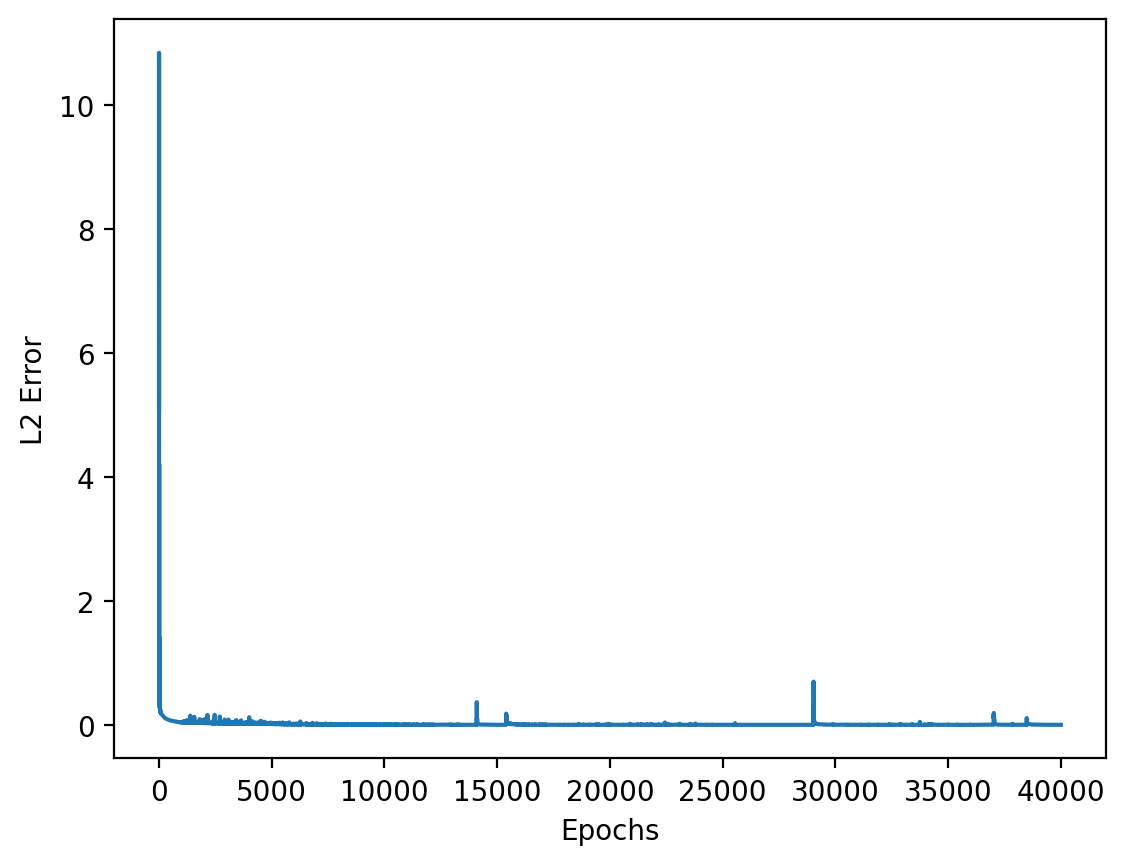

In [ ]:

#tf.enable_eager_execution()
#tf.executing_eagerly()
#tf.compat.v1.disable_eager_execution()
#print(tf.executing_eagerly())


optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3, beta_1 =.90)

it = 0 #starting iteration no.
epochs = 40000
loss_list = []



import time

start_time = time.time()

while it < epochs: #loop stops when "iteration no." catches up to epoch no.

  with tf.GradientTape() as tape:
    initial_loss = reconstruction(X_i, Y_i) + ini_transfer_speed(X_i)

    #boundary_loss = bound_block_vert(X_xblock) + bound_block_vert(X_yblock) + domain_boundaries(X_b)
    boundary_loss = bound_block_vert(X_block_bound) + domain_boundaries(X_b)


    domain_loss = pde(X_f)
    block_loss = block( X_block ) #loss inside the block



    loss = initial_loss + 10*boundary_loss + domain_loss + block_loss

    grads = tape.gradient( loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    loss_list.append(loss)

    it += 1 #increase iteration no. by 1 each time


    print('Iteration: %d, Initial_Loss: %.3e, Boundary_Loss: %.3e, Domain_Loss: %.3e, Block_loss: %.3e'   %    (it, initial_loss, boundary_loss, domain_loss,  block_loss ) )

train_time = time.time() - start_time

plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('L2 Error')

In [ ]:
XY_star = np.hstack((   Xvalues_mesh.flatten()[:, None],  Yvalues_mesh.flatten()[:, None]    ))
print(t_range[0])
t = np.arange(  int(t_range[0]),    int(t_range[1]) +dt ,    dt)

T_star = np.expand_dims(   np.repeat(t, len(XY_star)),   1)


XY_star_tiled = np.tile(  XY_star, (len(t), 1)  )

XYT_star = np.hstack((  XY_star_tiled, T_star  ))


0


In [ ]:
print(np.shape(XYT_star))
print(len(XYT_star))
print(XYT_star)

(84711, 3)
84711
[[  0.    0.    0. ]
 [  0.2   0.    0. ]
 [  0.4   0.    0. ]
 ...
 [ 29.6  10.  100. ]
 [ 29.8  10.  100. ]
 [ 30.   10.  100. ]]


In [ ]:
#XYT_star = LHS_Sampling(N_i, lb, ub)

In [ ]:
u_pred = model(tf.convert_to_tensor(XYT_star, dtype=tf.float32) ).numpy()
print(np.shape(u_pred))


#l2_error = np.mean(   (u_actual - u_pred)**2   )

print('')

grid_length = len(x)
print(grid_length)

u_pred = u_pred.reshape( len(t), no_y, no_x)

(84711, 1)

151


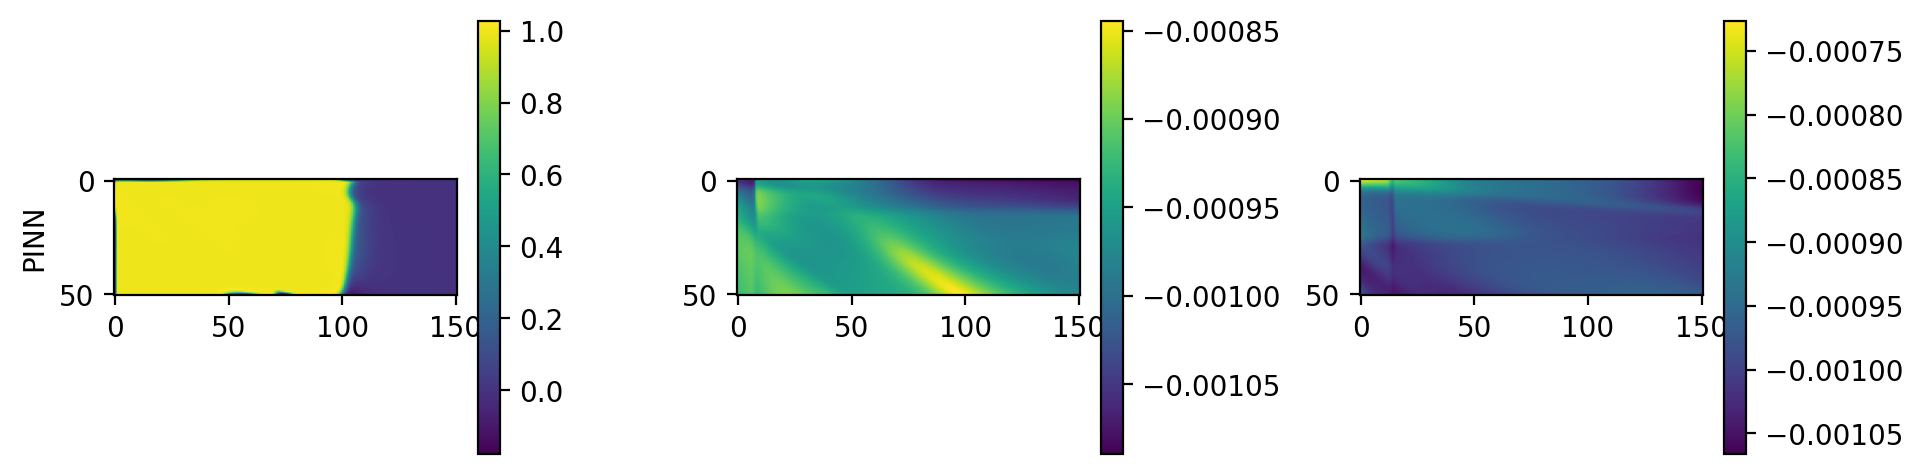

In [ ]:
u_field = u_pred


fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(2, 3, 4)
im1 = ax.imshow(u_field[0])
fig.colorbar(im1)
ax.set_ylabel("PINN")

ax = fig.add_subplot(2, 3, 5)
im2 = ax.imshow(u_field[int(len(t) / 2)])
fig.colorbar(im2)


ax = fig.add_subplot(2, 3, 6)
im3 = ax.imshow(u_field[-1])
fig.colorbar(im3)

fig.tight_layout()
plt.show()

In [ ]:
print(np.shape(u_pred))
print(u_pred)

(11, 51, 151)
[[[ 6.66958392e-01  8.17210853e-01  8.94919813e-01 ...  7.00757504e-01
    6.96651936e-01  6.92316592e-01]
  [ 7.35112071e-01  8.77217412e-01  9.46698308e-01 ...  7.66754806e-01
    7.62996256e-01  7.59135425e-01]
  [ 7.92003512e-01  9.25110877e-01  9.87039328e-01 ...  8.23420942e-01
    8.20019424e-01  8.16594243e-01]
  ...
  [ 8.05712044e-01  9.11673903e-01  9.71406400e-01 ...  9.44473267e-01
    9.42863464e-01  9.41101432e-01]
  [ 8.06737363e-01  9.12016809e-01  9.71200705e-01 ...  9.45040345e-01
    9.43296969e-01  9.41437483e-01]
  [ 8.07677984e-01  9.12248135e-01  9.71168637e-01 ...  9.45139647e-01
    9.43491936e-01  9.41944420e-01]]

 [[ 9.64083895e-03  1.26356743e-02  1.48944594e-02 ... -6.38351170e-03
   -6.36266498e-03 -6.38900278e-03]
  [ 8.12433288e-03  1.11216716e-02  1.37575902e-02 ... -4.77072177e-03
   -4.90341661e-03 -4.99085663e-03]
  [ 6.88320072e-03  9.83310863e-03  1.26805715e-02 ... -3.61091970e-03
   -3.79949389e-03 -3.71209858e-03]
  ...
  [ 7.208